# Setup

In [ ]:
%pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 649.4 kB/s eta 0:00:00


In [ ]:
import random
import numpy as np
import einops
import matplotlib.pyplot as plt

# Z1R

## Z1R HMM

In [ ]:
# implement the Z1R HMM generative structure

class Z1R:
  # 3 states: map indices to states 0,1,2 -> S0, S1, SR
  # 2 tokens: map indices to tokens 0,1 -> 0,1

  # entry s', s -> P(end=s'|start=s)
  state_transition_matrix = np.array([
      [0, 0, 1],
      [1, 0, 0],
      [0, 1, 0],
      ])

  # entry s, s', t -> P(token=t|start=s,end=s')
  token_transition_tensor = np.zeros([3,3,2]) # shape: state state token
  # fill in the nonzero edges
  token_transition_tensor[0][1] = np.array([1, 0,])
  token_transition_tensor[1][2] = np.array([0, 1,])
  token_transition_tensor[2][0] = np.array([0.5, 0.5,])

  def __init__(self, init_state : int = None):
    # initialize hidden state
    self.state = random.randint(0,2) if init_state is None else init_state
    self.state_onehot = np.eye(3)[self.state] # shape s
    assert self.state_onehot[self.state]==1 and self.state_onehot.sum()==1

  def step(self):
    """takes one step as per the transition probabilities,
    returning the token"""

    # pre step sanity check
    assert self.state in (0,1,2)
    assert self.state_onehot[self.state]==1 and self.state_onehot.sum()==1

    # record origin state
    old_state = self.state
    # update to new state
    self.state_onehot = einops.einsum(self.state_transition_matrix, self.state_onehot, "sn s, s -> sn ")
    # self.state_onehot = np.matmul(self.state_transition_matrix, self.state_onehot)
    self.state = np.argmax(self.state_onehot)

    # token emission
    token_probs = self.token_transition_tensor[old_state][self.state]
    token = np.random.choice([0,1], p=token_probs) # sample a token
    return token

In [ ]:
Z1R_instance = Z1R()

In [ ]:
print(f"initial state: {Z1R_instance.state}")
print(f"initial state onehot: {Z1R_instance.state_onehot}")

initial state: 2
initial state onehot: [0. 0. 1.]


In [ ]:
Z1R_instance.token_transition_tensor

array([[[0. , 0. ],
        [1. , 0. ],
        [0. , 0. ]],

       [[0. , 0. ],
        [0. , 0. ],
        [0. , 1. ]],

       [[0.5, 0.5],
        [0. , 0. ],
        [0. , 0. ]]])

In [ ]:
tokens = []
for _ in range(50):
  tokens.append(Z1R_instance.step())
print(np.array(tokens))

[1 0 1 0 0 1 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0
 0 1 0 0 1 0 0 1 1 0 1 0 0]


In [ ]:
# TEST: check the tokens generated are correct
# and the R token distribution is 50/50
Z1R_instance = Z1R(0)
Z_tokens = []
One_tokens = []
R_tokens = []

for i in range(1000): # only every third token is used  for each
  token = Z1R_instance.step()
  if i%3 == 0:
    Z_tokens.append(token)
  elif (i+2)%3 == 0:
    One_tokens.append(token)
  elif (i+1)%3 == 0:
    R_tokens.append(token)

assert np.array(Z_tokens).mean() == 0.
assert np.array(One_tokens).mean() == 1.

print(np.array(Z_tokens).mean())
print(np.array(One_tokens).mean())
print(np.array(R_tokens).mean()) # should be around 0.5

0.0
1.0
0.5165165165165165


## Z1R MSP

In [ ]:
# now implement the predictive structure for Z1R
class Z1R_MSP:
  def __init__(self, belief_prior : np.array = None, Z1R_instance : Z1R = None):
    # initialize the belief, uniformly if not specified
    self.belief_state = np.array([1/3, 1/3, 1/3]) if belief_prior is None else belief_prior

    # give it an instance of the Z1R HMM
    self.HMM = Z1R() if Z1R_instance is None else Z1R_instance

  def step(self, printing : bool = False):
    # sanity check
    assert self.belief_state.sum() == 1.

    token = self.HMM.step()
    if printing: print(f"token emitted: {token}")

    # Bayesian update using transition matrices
    unnormed_posterior = einops.einsum(self.HMM.token_transition_tensor[:,:,token], self.HMM.state_transition_matrix, self.belief_state,
                  "s sn, sn s, s -> sn") # Bayes theorem, without normalization
    norm_factor = 1/unnormed_posterior.sum()
    self.belief_state = norm_factor * unnormed_posterior # update belief state
    return self.belief_state

In [ ]:
Z1R_MSP_instance = Z1R_MSP()
print(f"initial belief state: {Z1R_MSP_instance.belief_state}") # initial belief state
print(f"actual HMM hidden state: {Z1R_MSP_instance.HMM.state}") # actual HMM state

initial belief state: [0.33333333 0.33333333 0.33333333]
actual HMM hidden state: 0


In [ ]:
for _ in range(10):
  updated_belief = Z1R_MSP_instance.step(printing=True)
  print(f"updated belief state {updated_belief}")

token emitted: 0
updated belief state [0.33333333 0.66666667 0.        ]
token emitted: 1
updated belief state [0. 0. 1.]
token emitted: 1
updated belief state [1. 0. 0.]
token emitted: 0
updated belief state [0. 1. 0.]
token emitted: 1
updated belief state [0. 0. 1.]
token emitted: 1
updated belief state [1. 0. 0.]
token emitted: 0
updated belief state [0. 1. 0.]
token emitted: 1
updated belief state [0. 0. 1.]
token emitted: 0
updated belief state [1. 0. 0.]
token emitted: 0
updated belief state [0. 1. 0.]


In [ ]:
set(map(tuple, np.expand_dims(np.array([1/3,1/3,1/3]),0) ))

{(0.3333333333333333, 0.3333333333333333, 0.3333333333333333)}

In [ ]:
# set off a bunch of runs, and record all the belief states reached

recorded_belief_states = set(map(tuple, np.expand_dims(np.array([1/3,1/3,1/3]),0) )) # cursed array wrangling

# run this lots of times
for _ in range(100):
  Z1R_MSP_instance = Z1R_MSP()
  for _ in range(4): # only a few steps needed, as we expect quick synchronization
    new_belief_state = Z1R_MSP_instance.step(printing=False)
    # print(new_belief_state)
    # print(set(map(tuple,np.expand_dims(new_belief_state,0))))
    recorded_belief_states.update( set(map(tuple,np.expand_dims(new_belief_state,0))) )

print(f"there are: {len(recorded_belief_states)} recorded belief states")
print(f"they are: {recorded_belief_states}")

there are: 7 recorded belief states
they are: {(1.0, 0.0, 0.0), (0.3333333333333333, 0.3333333333333333, 0.3333333333333333), (0.0, 1.0, 0.0), (0.3333333333333333, 0.0, 0.6666666666666666), (0.5, 0.5, 0.0), (0.0, 0.0, 1.0), (0.3333333333333333, 0.6666666666666666, 0.0)}


In [ ]:
# plot recorded_belief_states in simplex
# the target domain is an equilateral triangle, vertices (1,0), (0,1), (1/2, sqrt(3)/2)
# adopt the convention that triangle bottom left is [0,0,1], triangle bottom right is [1,0,0], and triangle tip is [0,1,0]

def convert_beliefs_to_simplex_points(belief : tuple):
  """a bit of trigonometry"""
  return np.array([belief[0]+belief[1]/2, belief[1]*np.sqrt(3)/2])

In [ ]:
simplex_points_xy = []

for belief_state in recorded_belief_states:
  assert type(belief_state) == tuple
  print(convert_beliefs_to_simplex_points(belief_state))
  simplex_points_xy.append(convert_beliefs_to_simplex_points(belief_state))

simplex_points_xy = np.array(simplex_points_xy)
print(simplex_points_xy)

[1. 0.]
[0.5        0.28867513]
[0.5       0.8660254]
[0.33333333 0.        ]
[0.75      0.4330127]
[0. 0.]
[0.66666667 0.57735027]
[[1.         0.        ]
 [0.5        0.28867513]
 [0.5        0.8660254 ]
 [0.33333333 0.        ]
 [0.75       0.4330127 ]
 [0.         0.        ]
 [0.66666667 0.57735027]]


In [ ]:
simplex_data = np.transpose(simplex_points_xy)
print(simplex_data)

[[1.         0.5        0.5        0.33333333 0.75       0.
  0.66666667]
 [0.         0.28867513 0.8660254  0.         0.4330127  0.
  0.57735027]]


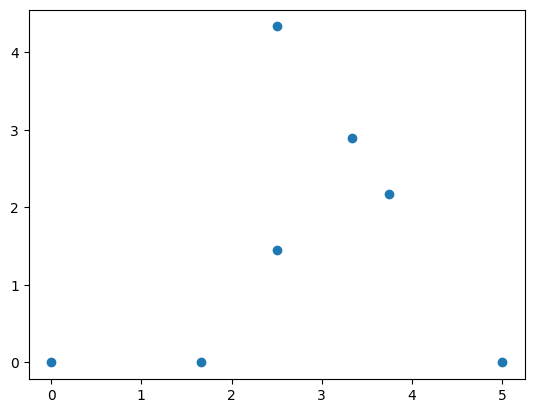

In [ ]:
scale = 1.
plt.scatter(scale*simplex_data[0], scale*simplex_data[1])

In [ ]:
# NOTE: this looks different to the Z1R simplex graphic in the post,
# either the post's graphic has an error or there's something wrong with my understanding, or maybe we have different conventions or something

# Mess3

## Mess3 HMM

In [ ]:
# now lets try the full Mess3 process
# again, first implement the Mess3 HMM generative structure

class Mess3:
  n_states = 3 # map indices -> states via 0,1,2 -> H0, H1, H2
  n_tokens = 3 # map indices -> tokens via 0,1,2 -> A,B,C

  # entry s', s -> P(end=s'|start=s)
  state_transition_matrix = np.array([
      [0.7, 0.15, 0.15],
      [0.15, 0.7, 0.15],
      [0.15, 0.15, 0.7],
      ])

  # entry s, s', t -> P(token=t|start=s,end=s')
  token_transition_tensor = np.zeros([n_states,n_states,n_tokens]) # shape: state state token
  # there are essentially three token probability distributions on edges
  edge_a = np.array([0.6, 0.2, 0.2])
  edge_b = np.array([0.2, 0.6, 0.2])
  edge_c = np.array([0.2, 0.2, 0.6])
  # fill in the nonzero edges
  token_transition_tensor[0][0]=token_transition_tensor[0][1]=token_transition_tensor[0][2] = edge_a
  token_transition_tensor[1][0]=token_transition_tensor[1][1]=token_transition_tensor[2][1] = edge_b
  token_transition_tensor[1][2]=token_transition_tensor[2][0]=token_transition_tensor[2][2] = edge_c

  def __init__(self, init_state : int = None):
    # initialize hidden state
    self.state = random.randint(0,self.n_states-1) if init_state is None else init_state
    self.state_onehot = np.eye(self.n_states)[self.state] # shape s
    assert self.state_onehot[self.state]==1 and self.state_onehot.sum()==1

  def step(self):
    """takes one step as per the transition probabilities,
    returning the token"""

    # pre step sanity check
    assert self.state in (0,1,2)
    # check state_onehot is correct
    assert self.state_onehot[self.state]==1.0, f"self.state_onehot[self.state]: {self.state_onehot[self.state]}"
    assert self.state_onehot.sum()==1.0, f"self.state_onehot.sum: {self.state_onehot.sum()}"

    # record origin state
    old_state = self.state
    # update to new state
    new_state_probs = einops.einsum(self.state_transition_matrix, self.state_onehot, "sn s, s -> sn ")
    self.state = np.random.choice([0,1,2], p=new_state_probs) # random sample
    self.state_onehot = np.eye(self.n_states)[self.state]

    # token emission
    token_probs = self.token_transition_tensor[old_state][self.state]
    token = np.random.choice([0,1,2], p=token_probs) # sample a token
    return token

In [ ]:
Mess3_instance = Mess3()

In [ ]:
print(f"initial state: {Mess3_instance.state}")
print(f"initial state onehot: {Mess3_instance.state_onehot}")

initial state: 1
initial state onehot: [0. 1. 0.]


In [ ]:
Mess3_instance.token_transition_tensor

array([[[0.6, 0.2, 0.2],
        [0.6, 0.2, 0.2],
        [0.6, 0.2, 0.2]],

       [[0.2, 0.6, 0.2],
        [0.2, 0.6, 0.2],
        [0.2, 0.2, 0.6]],

       [[0.2, 0.2, 0.6],
        [0.2, 0.6, 0.2],
        [0.2, 0.2, 0.6]]])

In [ ]:
tokens = []
for _ in range(50):
  tokens.append(Mess3_instance.step())
print(np.array(tokens))

[0 1 1 2 2 2 1 1 0 0 0 0 1 1 0 0 1 1 0 2 0 2 2 0 0 2 0 2 0 1 1 1 0 1 2 2 2
 1 1 1 2 2 0 1 1 1 1 0 2 1]


In [ ]:
# Tests?

## Mess3 MSP

In [ ]:
# now implement the predictive structure for Z1R
class Mess3_MSP:
  def __init__(self, belief_prior : np.array = None, Mess3_instance : Mess3 = None):
    # initialize the belief, uniformly if not specified
    self.belief_state = np.array([1/3, 1/3, 1/3]) if belief_prior is None else belief_prior

    # give it an instance of the Mess3 HMM
    self.HMM = Mess3() if Mess3_instance is None else Mess3_instance

  def step(self, printing : bool = False):
    # sanity check
    assert np.absolute(self.belief_state.sum() - 1.)<0.00001, f"self.belief_state.sum: {self.belief_state.sum()}" # get slight errors

    token = self.HMM.step()
    if printing: print(f"token emitted: {token}")

    # Bayesian update using transition matrices
    unnormed_posterior = einops.einsum(self.HMM.token_transition_tensor[:,:,token], self.HMM.state_transition_matrix, self.belief_state,
                  "s sn, sn s, s -> sn") # Bayes theorem, without normalization
    norm_factor = 1/unnormed_posterior.sum()
    self.belief_state = norm_factor * unnormed_posterior # update belief state
    return self.belief_state

In [ ]:
Mess3_MSP_instance = Mess3_MSP()
print(f"initial belief state: {Mess3_MSP_instance.belief_state}") # initial belief state
print(f"actual HMM hidden state: {Mess3_MSP_instance.HMM.state}") # actual HMM state

initial belief state: [0.33333333 0.33333333 0.33333333]
actual HMM hidden state: 1


In [ ]:
for _ in range(1000):
  updated_belief = Mess3_MSP_instance.step(printing=True)
  print(f"updated belief state {updated_belief}")

token emitted: 0
updated belief state [0.44056789 0.35958412 0.19984799]
token emitted: 1
updated belief state [0.29928997 0.54518764 0.15552239]
token emitted: 0
updated belief state [0.45891695 0.33757473 0.20350831]
token emitted: 2
updated belief state [0.32023571 0.23193589 0.4478284 ]
token emitted: 1
updated belief state [0.25886443 0.48188176 0.25925381]
token emitted: 0
updated belief state [0.43142465 0.32462603 0.24394932]
token emitted: 1
updated belief state [0.2982503  0.52687982 0.17486988]
token emitted: 0
updated belief state [0.45824479 0.33151193 0.21024328]
token emitted: 0
updated belief state [0.54452545 0.2451383  0.21033625]
token emitted: 1
updated belief state [0.35343814 0.46702511 0.17953675]
token emitted: 1
updated belief state [0.26220237 0.60318094 0.13461669]
token emitted: 1
updated belief state [0.23001611 0.66153197 0.10845192]
token emitted: 1
updated belief state [0.22018435 0.68262744 0.09718821]
token emitted: 2
updated belief state [0.21916501 0

above^: doesn't visibly synchronize

In [ ]:
# set off a bunch of runs, and record all the belief states reached

recorded_belief_states = set(map(tuple, np.expand_dims(np.array([1/3,1/3,1/3]),0) )) # cursed array wrangling

# run this lots of times
for _ in range(100):
  Mess3_MSP_instance = Mess3_MSP()
  for _ in range(100): # DON'T necessarily expect quick synchronization?
    new_belief_state = Mess3_MSP_instance.step(printing=False)
    # print(new_belief_state)
    # print(set(map(tuple,np.expand_dims(new_belief_state,0))))
    recorded_belief_states.update( set(map(tuple,np.expand_dims(new_belief_state,0))) )

print(f"there are: {len(recorded_belief_states)} recorded belief states")
print(f"they are: {recorded_belief_states}")

there are: 9664 recorded belief states
they are: {(0.3220961122378423, 0.17269386793730673, 0.5052100198248508), (0.3738232294396303, 0.43542114168968027, 0.19075562887068934), (0.5326495357487522, 0.20842294070211648, 0.2589275235491315), (0.3995776765771942, 0.3893793325685349, 0.211042990854271), (0.24666291066376583, 0.32551708317995964, 0.42782000615627447), (0.43523304283266495, 0.20138018485063044, 0.3633867723167048), (0.4744475660410169, 0.20728913170362814, 0.318263302255355), (0.5217021130492209, 0.22303492291317414, 0.25526296403760507), (0.4051761460780416, 0.4039574718366398, 0.1908663820853187), (0.47619985426532674, 0.31696556721459085, 0.20683457852008244), (0.22317044720640314, 0.5896054767768848, 0.1872240760167121), (0.3416751522541322, 0.46791391507569036, 0.19041093267017728), (0.2814541928514529, 0.44329152524220294, 0.27525428190634416), (0.22950215279130554, 0.11196232903344322, 0.6585355181752514), (0.5871470826110506, 0.20357219853764244, 0.2092807188513069),

Note the convert_beliefs_to_simplex_points function is the same as before

In [ ]:
simplex_points_xy = []

for belief_state in recorded_belief_states:
  assert type(belief_state) == tuple
  print(convert_beliefs_to_simplex_points(belief_state))
  simplex_points_xy.append(convert_beliefs_to_simplex_points(belief_state))

simplex_points_xy = np.array(simplex_points_xy)
print(simplex_points_xy)

Streaming output truncated to the last 5000 lines.
[0.55305057 0.23896847]
[0.60679735 0.35973782]
[0.38568823 0.17003007]
[0.56094904 0.59014964]
[0.30233797 0.13131407]
[0.59901388 0.3364085 ]
[0.28780954 0.12232394]
[0.31918721 0.17686199]
[0.57198669 0.3854848 ]
[0.59734031 0.37344817]
[0.26468939 0.08114256]
[0.45362127 0.16816525]
[0.56198992 0.59602788]
[0.29862196 0.12799698]
[0.65328335 0.18989281]
[0.55554692 0.57429772]
[0.68308003 0.1862548 ]
[0.45632869 0.15759857]
[0.53451025 0.17543033]
[0.27743341 0.10048927]
[0.42221761 0.34886664]
[0.27353121 0.09877733]
[0.58211638 0.31439126]
[0.28100451 0.11150971]
[0.50659876 0.1847704 ]
[0.61928461 0.26052534]
[0.40427636 0.31894984]
[0.68541352 0.17695653]
[0.6824779  0.19084013]
[0.45046915 0.39822411]
[0.49228741 0.44001124]
[0.34868109 0.20315097]
[0.54524398 0.39799108]
[0.53868789 0.55082613]
[0.67664917 0.19916051]
[0.5471776  0.42562999]
[0.32525115 0.13074008]
[0.54592621 0.56914677]
[0.56413855 0.38575473]
[0.31833406 0

In [ ]:
simplex_data = np.transpose(simplex_points_xy)
print(simplex_data)

[[0.40844305 0.5915338  0.63686101 ... 0.50932108 0.29630649 0.35895176]
 [0.14955728 0.37708577 0.18049956 ... 0.50619911 0.12632987 0.12762085]]


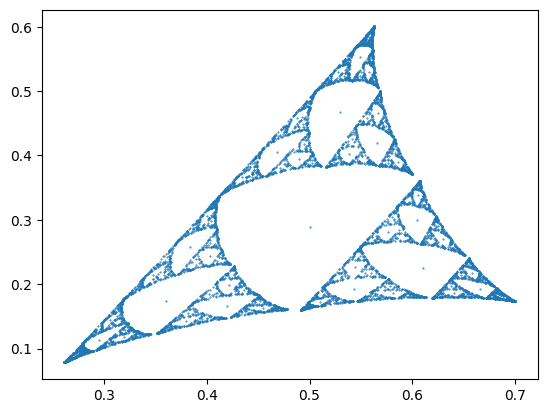

In [ ]:
scale = 1.
plt.scatter(scale*simplex_data[0], scale*simplex_data[1], s=0.2) # s=... contrls size of points in the plot

Is a little wonky -- accumulated numerical error?

## Try this with fewer datapoints, to see if it still suffices

In [ ]:
recorded_belief_states = set(map(tuple, np.expand_dims(np.array([1/3,1/3,1/3]),0) )) # cursed array wrangling

for _ in range(1):
  Mess3_MSP_instance = Mess3_MSP()
  for _ in range(1000):
    new_belief_state = Mess3_MSP_instance.step(printing=False)
    # print(new_belief_state)
    # print(set(map(tuple,np.expand_dims(new_belief_state,0))))
    recorded_belief_states.update( set(map(tuple,np.expand_dims(new_belief_state,0))) )

print(f"there are: {len(recorded_belief_states)} recorded belief states")

there are: 1001 recorded belief states


In [ ]:
simplex_points_xy = []

for belief_state in recorded_belief_states:
  assert type(belief_state) == tuple
  simplex_points_xy.append(convert_beliefs_to_simplex_points(belief_state))

simplex_points_xy = np.array(simplex_points_xy)
simplex_data = np.transpose(simplex_points_xy)

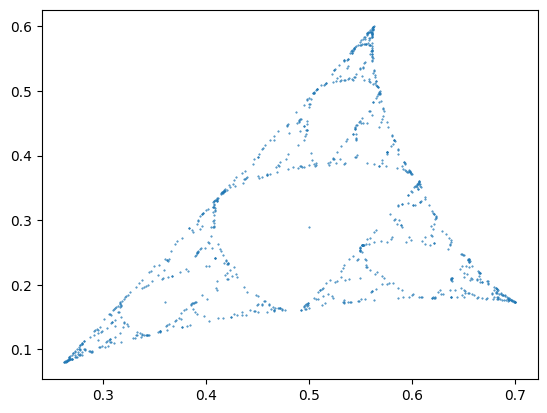

In [ ]:
scale = 1.
plt.scatter(scale*simplex_data[0], scale*simplex_data[1], s=0.2)

^above shows even a single instance will wander around the entire simplex and draw out the entire fractal structure

# Try other generative HMMs, to make other fractals

Create a more flexible HMM and MSP class

In [ ]:
# a test HMM generator
class TestHMM:
  n_states = 3 # keep it at 3 states, so we can still plot a 2D simplex

  def __init__(self,
               state_transition_matrix : np.ndarray = np.ones((n_states, n_states))/n_states, # defaults to uniform transitions
               init_state : int = random.randint(0,n_states-1), # defaults to random initial state
               n_tokens : int = 3,
               token_transition_tensor : np.ndarray = None
               ):
    self.n_tokens = n_tokens
    self.state_transition_matrix = state_transition_matrix

    assert np.array_equal(self.state_transition_matrix.sum(axis=0), np.ones(self.n_states)), f"transition matrix col sum: {state_transition_matrix.sum(axis=0)}"

    # entry s, s', t -> P(token=t|start=s,end=s')
    if token_transition_tensor is None:
      self.token_transition_tensor = np.ones((self.n_states,self.n_states,self.n_tokens))/self.n_tokens # default to uniform token transition probabilities
    else:
      self.token_transition_tensor = token_transition_tensor
      assert token_transition_tensor.shape[-1] == self.n_tokens

    # initialize hidden state
    self.state = init_state
    self.state_onehot = np.eye(self.n_states)[self.state] # shape s
    assert self.state_onehot[self.state]==1 and self.state_onehot.sum()==1

  def step(self):
    """takes one step as per the transition probabilities,
    returning the token"""

    # pre step sanity check
    assert self.state in (0,1,2)
    # check state_onehot is correct
    assert self.state_onehot[self.state]==1.0, f"self.state_onehot[self.state]: {self.state_onehot[self.state]}"
    assert self.state_onehot.sum()==1.0, f"self.state_onehot.sum: {self.state_onehot.sum()}"

    # record origin state
    old_state = self.state
    # update to new state
    new_state_probs = einops.einsum(self.state_transition_matrix, self.state_onehot, "sn s, s -> sn ")
    self.state = np.random.choice([0,1,2], p=new_state_probs) # random sample
    self.state_onehot = np.eye(self.n_states)[self.state]

    # token emission
    token_probs = self.token_transition_tensor[old_state][self.state]
    token = np.random.choice(list(range(self.n_tokens)), p=token_probs) # sample a token
    return token

  def reset(self, init_state : int = random.randint(0,n_states-1)):
    # reset the hidden state
    self.state = init_state
    self.state_onehot = np.eye(self.n_states)[self.state] # shape s
    assert self.state_onehot[self.state]==1 and self.state_onehot.sum()==1


Try randomly generating a state transition matrix, keeping all else the same

In [ ]:
# randomly generate a state transition matrix
state_transition_matrix = np.random.rand(3,3)
state_transition_matrix = state_transition_matrix/state_transition_matrix.sum(axis=0)[None,:]

# keep token transition tensors as was
token_transition_tensor = np.zeros([3,3,3]) # shape: state state token
edge_a = np.array([0.6, 0.2, 0.2])
edge_b = np.array([0.2, 0.6, 0.2])
edge_c = np.array([0.2, 0.2, 0.6])
token_transition_tensor[0][0]=token_transition_tensor[0][1]=token_transition_tensor[0][2] = edge_a
token_transition_tensor[1][0]=token_transition_tensor[1][1]=token_transition_tensor[2][1] = edge_b
token_transition_tensor[1][2]=token_transition_tensor[2][0]=token_transition_tensor[2][2] = edge_c


# instantiate HMM with given matrix
TestHMM_instance = TestHMM(state_transition_matrix=state_transition_matrix, token_transition_tensor=token_transition_tensor)

In [ ]:
TestHMM_instance.state_transition_matrix

array([[0.294917  , 0.24965079, 0.00436926],
       [0.41177382, 0.20679653, 0.19885637],
       [0.29330918, 0.54355268, 0.79677437]])

In [ ]:
# generate some tokens with it
tokens = []
for _ in range(50):
  tokens.append(Mess3_instance.step())
print(np.array(tokens))

[1 1 0 1 1 0 1 0 2 1 1 1 0 0 2 0 2 2 0 2 2 1 0 1 2 1 1 1 0 2 0 2 2 0 0 0 2
 2 2 0 0 2 1 0 1 1 2 2 1 2]


In [ ]:
# predictive structure class, for arbitrary generative HMM
class TestMSP:
  def __init__(self, belief_prior : np.array = None, TestHMM_instance : TestHMM = None):
    # give it an instance of the TestHMM
    self.HMM = TestHMM() if TestHMM_instance is None else TestHMM_instance

    # initialize the belief, uniformly if not specified
    self.belief_state = np.ones(self.HMM.n_states)/self.HMM.n_states if belief_prior is None else belief_prior
    assert len(self.belief_state) == self.HMM.n_states

  def step(self, printing : bool = False):
    # sanity check
    assert np.absolute(self.belief_state.sum() - 1.)<0.00001, f"self.belief_state.sum: {self.belief_state.sum()}" # NOTE: get slight errors

    token = self.HMM.step()
    if printing: print(f"token emitted: {token}")

    # Bayesian update using transition matrices
    unnormed_posterior = einops.einsum(self.HMM.token_transition_tensor[:,:,token], self.HMM.state_transition_matrix, self.belief_state,
                  "s sn, sn s, s -> sn") # Bayes theorem, without normalization
    norm_factor = 1/unnormed_posterior.sum()
    self.belief_state = norm_factor * unnormed_posterior # update belief state
    return self.belief_state

  def reset(self, belief_prior : np.ndarray = None):
    """reset the MSP and the HMM"""
    self.belief_state = np.ones(self.HMM.n_states)/self.HMM.n_states if belief_prior is None else belief_prior
    assert len(self.belief_state) == self.HMM.n_states
    self.HMM.reset()


In [ ]:
TestMSP_instance = TestMSP(TestHMM_instance=TestHMM_instance)
print(f"initial belief state: {TestMSP_instance.belief_state}") # initial belief state
print(f"actual HMM hidden state: {TestMSP_instance.HMM.state}") # actual HMM state

initial belief state: [0.33333333 0.33333333 0.33333333]
actual HMM hidden state: 2


In [ ]:
for _ in range(1000):
  updated_belief = TestMSP_instance.step(printing=True)
  print(f"updated belief state {updated_belief}")

token emitted: 2
updated belief state [0.09802023 0.14367557 0.7583042 ]
token emitted: 2
updated belief state [0.03150973 0.09314537 0.8753449 ]
token emitted: 2
updated belief state [0.01758135 0.08239631 0.90002235]
token emitted: 2
updated belief state [0.01483316 0.08028462 0.90488222]
token emitted: 2
updated belief state [0.01429893 0.07987362 0.90582745]
token emitted: 2
updated belief state [0.0141953  0.07979392 0.90601078]
token emitted: 2
updated belief state [0.01417521 0.07977847 0.90604632]
token emitted: 2
updated belief state [0.01417132 0.07977547 0.90605321]
token emitted: 0
updated belief state [0.03540929 0.20827482 0.75631589]
token emitted: 2
updated belief state [0.02967388 0.08532726 0.88499886]
token emitted: 1
updated belief state [0.05351827 0.41480554 0.53167619]
token emitted: 2
updated belief state [0.05484937 0.09273132 0.8524193 ]
token emitted: 1
updated belief state [0.06276151 0.41346752 0.52377097]
token emitted: 1
updated belief state [0.20839525 0

Seems fairly fluctuating

In [ ]:
# set off a bunch of runs, and record all the belief states reached
recorded_belief_states = set(map(tuple, np.expand_dims(np.ones(TestHMM.n_states)/TestHMM.n_states,0) )) # cursed array wrangling

# run this lots of times
for _ in range(100):
  TestMSP_instance.reset()
  for _ in range(100):
    new_belief_state = TestMSP_instance.step(printing=False)
    # print(new_belief_state)
    # print(set(map(tuple,np.expand_dims(new_belief_state,0))))
    recorded_belief_states.update( set(map(tuple,np.expand_dims(new_belief_state,0))) )

print(f"there are: {len(recorded_belief_states)} recorded belief states")

there are: 9644 recorded belief states


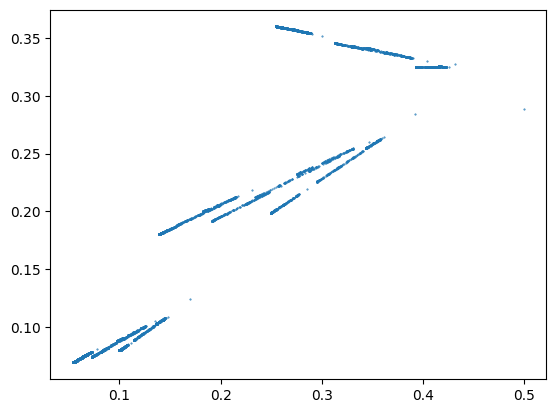

In [ ]:
simplex_points_xy = []

for belief_state in recorded_belief_states:
  assert type(belief_state) == tuple
  simplex_points_xy.append(convert_beliefs_to_simplex_points(belief_state))

simplex_points_xy = np.array(simplex_points_xy)
simplex_data = np.transpose(simplex_points_xy)

scale = 1.
plt.scatter(scale*simplex_data[0], scale*simplex_data[1], s=0.2) # s=... contrls size of points in the plot

Hard to tell, but doesn't look overly fractal-y at this level

Instead, try 4 tokens (instead of 3)

In [ ]:
# Mess3 state transition matrix
state_transition_matrix = np.array([
      [0.7, 0.15, 0.15],
      [0.15, 0.7, 0.15],
      [0.15, 0.15, 0.7],
      ])

# keep token transition tensors as was
token_transition_tensor = np.zeros([3,3,4]) # shape: state state token
edge_a = np.array([0.7, 0.1, 0.1, 0.1])
edge_b = np.array([0.1, 0.7, 0.1, 0.1])
edge_c = np.array([0.1, 0.1, 0.7, 0.1])
token_transition_tensor[0][0]=token_transition_tensor[0][1]=token_transition_tensor[0][2] = edge_a
token_transition_tensor[1][0]=token_transition_tensor[1][1]=token_transition_tensor[2][1] = edge_b
token_transition_tensor[1][2]=token_transition_tensor[2][0]=token_transition_tensor[2][2] = edge_c

TestHMM_instance = TestHMM(state_transition_matrix = state_transition_matrix, n_tokens = 4, token_transition_tensor=token_transition_tensor)

In [ ]:
TestMSP_instance = TestMSP(TestHMM_instance=TestHMM_instance)
print(f"initial belief state: {TestMSP_instance.belief_state}") # initial belief state
print(f"actual HMM hidden state: {TestMSP_instance.HMM.state}") # actual HMM state

initial belief state: [0.33333333 0.33333333 0.33333333]
actual HMM hidden state: 2


In [ ]:
for _ in range(1000):
  updated_belief = TestMSP_instance.step(printing=True)
  print(f"updated belief state {updated_belief}")

token emitted: 3
updated belief state [0.33333333 0.33333333 0.33333333]
token emitted: 0
updated belief state [0.57777778 0.21111111 0.21111111]
token emitted: 0
updated belief state [0.64800995 0.17599502 0.17599502]
token emitted: 2
updated belief state [0.32335148 0.12003932 0.5566092 ]
token emitted: 2
updated belief state [0.20999385 0.05473416 0.73527199]
token emitted: 1
updated belief state [0.16217175 0.55218616 0.28564209]
token emitted: 1
updated belief state [0.18073187 0.74387259 0.07539553]
token emitted: 0
updated belief state [0.48382299 0.34628269 0.16989432]
token emitted: 1
updated belief state [0.24932181 0.66727759 0.08340059]
token emitted: 2
updated belief state [0.17877921 0.25519744 0.56602334]
token emitted: 3
updated belief state [0.24832857 0.29035859 0.46131284]
token emitted: 0
updated belief state [0.53396625 0.21413617 0.25189758]
token emitted: 0
updated belief state [0.6390269  0.17801631 0.18295679]
token emitted: 1
updated belief state [0.31925951 0

In [ ]:
# set off a bunch of runs, and record all the belief states reached
recorded_belief_states = set(map(tuple, np.expand_dims(np.ones(TestHMM.n_states)/TestHMM.n_states,0) )) # cursed array wrangling

# run this lots of times
for _ in range(100):
  TestMSP_instance.reset()
  for _ in range(100):
    new_belief_state = TestMSP_instance.step(printing=False)
    # print(new_belief_state)
    # print(set(map(tuple,np.expand_dims(new_belief_state,0))))
    recorded_belief_states.update( set(map(tuple,np.expand_dims(new_belief_state,0))) )

print(f"there are: {len(recorded_belief_states)} recorded belief states")

there are: 9653 recorded belief states


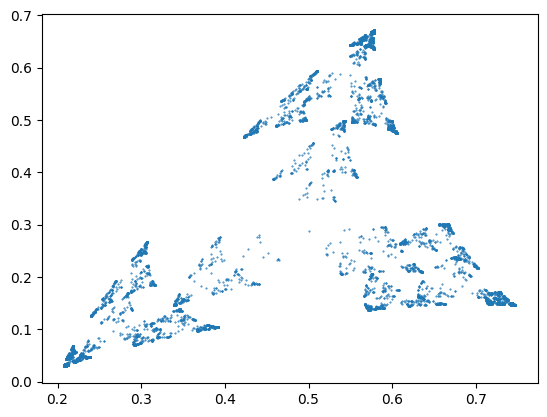

In [ ]:
simplex_points_xy = []

for belief_state in recorded_belief_states:
  assert type(belief_state) == tuple
  simplex_points_xy.append(convert_beliefs_to_simplex_points(belief_state))

simplex_points_xy = np.array(simplex_points_xy)
simplex_data = np.transpose(simplex_points_xy)

scale = 1.
plt.scatter(scale*simplex_data[0], scale*simplex_data[1], s=0.2) # s=... contrls size of points in the plot

This looks more fractal-y.
Has a cool structure